Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


There is a cow in the picture.
Animals found in text: ['cow']


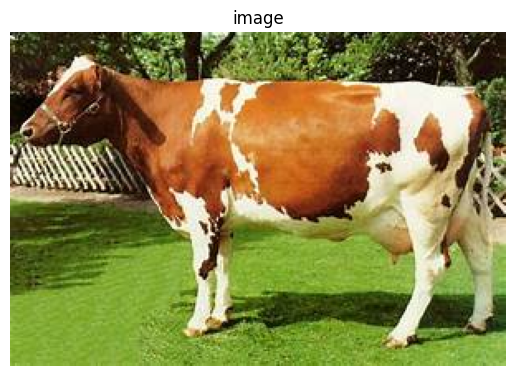

Animal detected in image: cow
Output: True


In [3]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoModelForTokenClassification, AutoTokenizer

#constants
CLASS_NAMES = ["butterfly", "cat", "chicken", "cow", "dog",
               "elephant", "horse", "sheep", "spider", "squirrel"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load NER model
def load_ner_model(model_path, tokenizer_path):
    model = AutoModelForTokenClassification.from_pretrained("bert-base-cased", num_labels=2)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    tokenizer = torch.load(tokenizer_path, weights_only=False)
    return model, tokenizer

#extract animals from text
def extract_animals(text, model, tokenizer):
    tokens = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**tokens).logits
    predictions = torch.argmax(outputs, dim=2)

    animals = [tokenizer.convert_ids_to_tokens(tokens["input_ids"][0][i].item())
               for i, label in enumerate(predictions[0]) if label.item() == 1]
    return animals

#load image classification model
def load_image_model(model_path):
    model = models.resnet18(pretrained=False)
    model.fc = torch.nn.Linear(model.fc.in_features, len(CLASS_NAMES))
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    model.to(DEVICE)
    model.eval()
    return model

#predict image class
def predict_image(image_path, model):
    #load and preprocess image
    image = Image.open(image_path).convert("RGB")

    plt.imshow(image)
    plt.axis("off")
    plt.title("image")
    plt.show()

    image = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
    return CLASS_NAMES[predicted.item()]

#pipeline function
def pipeline(text, image_path, ner_model_path, tokenizer_path, img_model_path):
    ner_model, tokenizer = load_ner_model(ner_model_path, tokenizer_path)
    animals_from_text = extract_animals(text, ner_model, tokenizer)

    if animals_from_text:
        print("Animals found in text:", animals_from_text)
        img_model = load_image_model(img_model_path)
        animal_from_image = predict_image(image_path, img_model)

        print(f"Animal detected in image: {animal_from_image}")

        return any(animal.lower() in animal_from_image.lower() for animal in animals_from_text)
    else:
        print("No animals found in text.")
        return False

if __name__ == "__main__":
    text = "There is a cow in the picture."
    print(text)
    image_path = "/content/img.jpeg"
    ner_model_path = "ner_model.pth"
    tokenizer_path = "ner_tokenizer.pth"
    img_model_path = "best_model.pth"

    result = pipeline(text, image_path, ner_model_path, tokenizer_path, img_model_path)

    #binary result
    print("Output:", result)
